In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis import tnp, tnp_mode
import pandas as pd

tnp_mode(1);

# NF example

In [2]:
from analysis.mc import ImportanceSamplingIntegrator

In [4]:
class NFlowImportanceSamplingIntegrator(ImportanceSamplingIntegrator):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        
    def sample(self, n_samples:int=1, with_importance:bool=False):
        pass
    
    def adapt(self, n_samples:int=1000000):
        self.adapted = True
        pass

In [5]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
from analysis.nis.distributions import HyperUniform
import numpy as np
import pandas as pd

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from normflows.distributions import BaseDistribution
from typing import Optional

class HyperUniform(BaseDistribution):
    """
    Multivariate uniform distribution
    """

    def __init__(self, low, high, dtype=torch.float, device:Optional[str]=None):
        """Constructor

        Args:
          low: Lower bound of uniform distribution
          high: Upper bound of uniform distribution
        """
        
        low = torch.tensor(low).to(dtype)
        high = torch.tensor(high).to(dtype)
        
        if device is not None:
            low = low.to(device)
            high = high.to(device)
        
        assert(low.shape == high.shape)
        
        shape = low.shape[0]
        
        super().__init__()
        if isinstance(shape, int):
            shape = (shape,)
        if isinstance(shape, list):
            shape = tuple(shape)
            
        self.shape = shape
        self.d = np.prod(shape)
        self.low = low
        self.high = high
        self.log_prob_val = -torch.sum(torch.log(self.high - self.low))

    def forward(self, num_samples=1, context=None):
        eps = torch.rand(
            (num_samples,) + self.shape, dtype=self.low.dtype, device=self.low.device
        )
        z = self.low + (self.high - self.low) * eps
        log_p = self.log_prob_val * torch.ones(num_samples, device=self.low.device)
        return z, log_p

    def log_prob(self, z, context=None):
        return torch.ones(z.shape[0], device=z.device)
        log_p = self.log_prob_val * torch.ones(z.shape[0], device=z.device)
        out_range = torch.logical_or(z < self.low, z > self.high)
        ind_inf = torch.any(torch.reshape(out_range, (z.shape[0], -1)), dim=-1)
        log_p[ind_inf] = -np.inf
        return log_p

In [ ]:
import normflows as nf
import torch
from typing import Optional, Callable

def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def get_nfm(q0:Optional[BaseDistribution]=None,
            K:int = 16,
            latent_size:int = 2,
            hidden_units: int = 256,
            hidden_layers:int = 2,
            cuda_if_available:bool = True,
            flow:Callable = nf.flows.CoupledRationalQuadraticSpline,#nf.flows.AutoregressiveRationalQuadraticSpline,
            linear_permute:bool = True,
            flow_args:dict = { 'num_bins': 30, 'tails': None, 'tail_bound': 1. },
            seed:Optional[int]=None):
    
    if seed is not None:
        torch.manual_seed(seed)

    flows = []
    for i in range(K):
        flows += [flow(latent_size, hidden_layers, hidden_units, **flow_args)]
        if linear_permute:
            flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribuiton
    if q0 is None:
        #q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
        q0 = nf.distributions.Uniform(latent_size)
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)

    print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
    print(f"Model with {sum(p.numel() for p in nfm.parameters())} parameters")
    
    # Move model on GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')
    return nfm.to(device)

: 

(array([[27., 20., 23., ..., 22., 22., 22.],
        [29., 23., 18., ..., 20., 19., 33.],
        [18., 26., 17., ..., 29., 30., 30.],
        ...,
        [27., 15., 19., ..., 29., 19., 29.],
        [15., 16., 26., ..., 32., 24., 24.],
        [31., 26., 26., ..., 25., 30., 24.]]),
 array([3.21865082e-06, 1.56280659e-02, 3.12529132e-02, 4.68777604e-02,
        6.25026077e-02, 7.81274550e-02, 9.37523022e-02, 1.09377149e-01,
        1.25001997e-01, 1.40626844e-01, 1.56251691e-01, 1.71876539e-01,
        1.87501386e-01, 2.03126233e-01, 2.18751080e-01, 2.34375928e-01,
        2.50000775e-01, 2.65625622e-01, 2.81250469e-01, 2.96875317e-01,
        3.12500164e-01, 3.28125011e-01, 3.43749858e-01, 3.59374706e-01,
        3.74999553e-01, 3.90624400e-01, 4.06249247e-01, 4.21874095e-01,
        4.37498942e-01, 4.53123789e-01, 4.68748637e-01, 4.84373484e-01,
        4.99998331e-01, 5.15623178e-01, 5.31248026e-01, 5.46872873e-01,
        5.62497720e-01, 5.78122567e-01, 5.93747415e-01, 6.09372262e

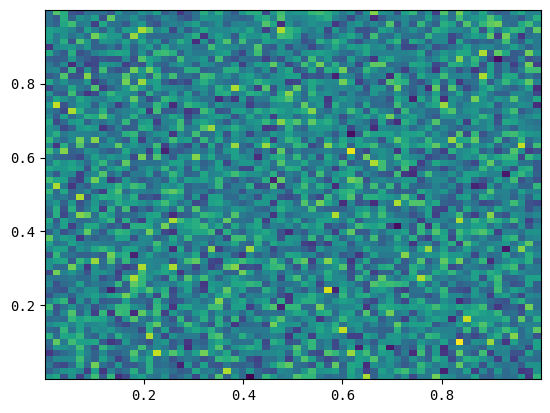

In [ ]:
#a = HyperUniform(low=[-2,-2], high=[2, 2], trainable=False)
a = nf.distributions.base.Uniform(2, low=0., high=1.)
#a = nf.distributions.base.DiagGaussian(2, trainable=False)

z = a.sample(100000)

pX = z.T[0].detach().cpu().numpy()
pY = z.T[1].detach().cpu().numpy()

plt.hist2d(pX, pY, bins=(64,64))

In [51]:
def plot_proposal(nfm, n_samples:int=1024):
    cs = nfm.sample(n_samples)
    samples = cs[0].detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    print(f'Using inferred bounds {all_min:.3f} to {all_max:.3f}')
    #print((all_min, all_max))

    plot_hist(pd.DataFrame(dict(x=samples.T[0], y=samples.T[1])), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))
    if False:
        fig, ax = plt.subplots()
        ax.set_title("q0")
        for i in range(len(samples.T)):
            ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}",
                    bins=64, range=(all_min, all_max))
            ax.set_xlim(all_min, all_max)
        ax.legend()
        
def plot_integrand(nfm, func, n_samples:int=2048, vwindow=None,
                   is_nfm:bool=True, y_log:bool=False):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
    else:
        samples = nfm.sample(n_samples)
    
    #samples = samples.detach().cpu().numpy()
    results = func(samples).detach().cpu().numpy()
    
    for i in range(len(samples.T)):
        fig, ax = plt.subplots()
        #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
        ax.scatter(x=samples.T[i].detach().cpu().numpy(),
                y=results)
        
        if vwindow is not None:
            if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                ax.set_ylim(vwindow[i])
            else:
                ax.set_ylim(vwindow)
            
        ax.set_title('Integrand projection')
        ax.set_xlabel(f"Dim {i}")
        ax.set_ylabel('Integrand value')
        plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(nfm, func:Callable, n_samples:int=1024, is_nfm:bool=True):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
        prob = log_p.exp().detach()#.cpu().numpy()
    else:
        samples = nfm.sample(n_samples)
        prob = torch.ones(n_samples) * nfm.log_prob_val.exp()
    
    res = func(samples)/prob
    
    integral = (1/n_samples * res.sum()).detach().cpu().numpy().item()
    delta = (torch.var(res).detach().cpu()/n_samples).sqrt().numpy().item()
    
    return integral, delta

CPU
Model with 1246080 parameters


Using inferred bounds 0.041 to 1.022


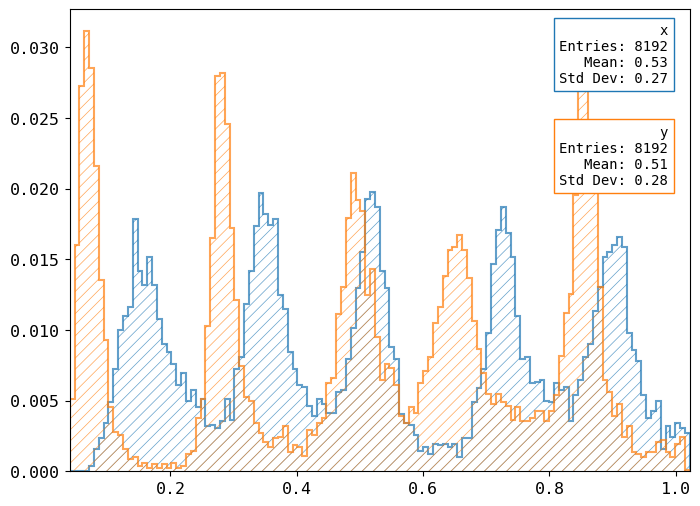

In [52]:
nfm = get_nfm(q0=a, hidden_units=128)
plot_proposal(nfm, n_samples=8192)

In [42]:
def func(args):
    return torch.exp(-1*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)

In [43]:
get_result(a, func, is_nfm=False, n_samples=10000)

(0.484367698431015, 0.0014434895711019635)

In [44]:
get_result(nfm, func)

(0.5448322296142578, 0.05643506348133087)

In [45]:
samples, log_p = nfm.sample(1000)
results = func(samples).detach().cpu().numpy()

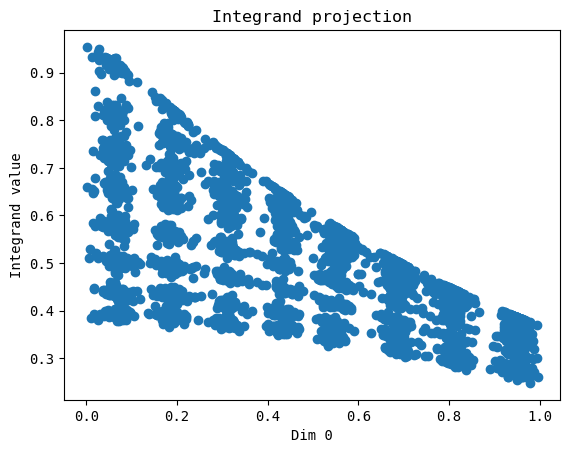

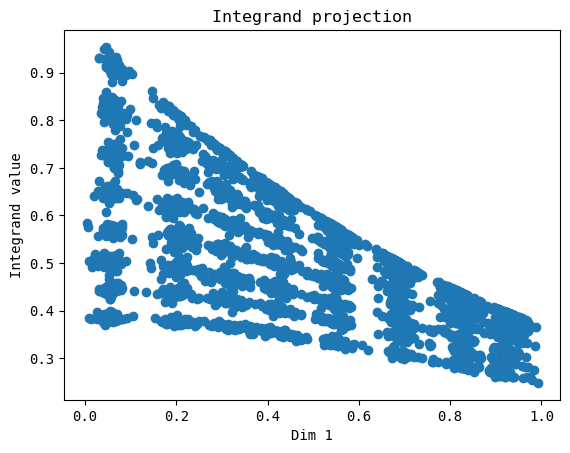

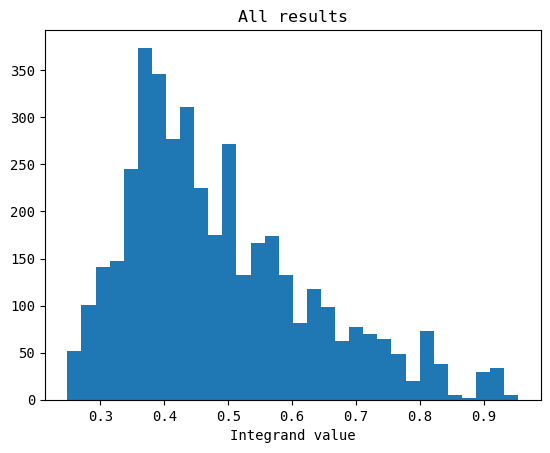

In [46]:
plot_integrand(nfm, func, n_samples=4096)

In [47]:
def train_iflow(nfm, func, n_samples:int=16384, n_epochs:int=10, lr:float=1e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        z, logq = nfm.q0(n_samples)
        true = torch.abs(func(z)).detach()
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16).detach()
        
        # Transform through NFlow
        for flow in nfm.flows:
            z, log_det = flow(z)
            logq -= log_det
        
        test = logq.exp().detach()
        
        mean = torch.mean(true/test)
        var = torch.var(true/test)
        
        true = true/mean
        loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}")
        
def train_backward(nfm, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3)
    p = nfm.q0.log_prob_val.exp()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [48]:
#train_forward(nfm, func, n_epochs=10)
train_iflow(nfm, func, n_epochs=10)

Epoch 0: 3.564826488494873 | Var 3.297308921813965


RuntimeError: index 8 is out of bounds for dimension 2 with size 8

In [22]:
from time import sleep

max_val = 0
thresh  = 1.98
n_samples = 8192

while max_val < thresh:
    samples, probs = nfm.sample(n_samples)
    sample_max = samples.max().item()
    
    max_val = max(max_val, sample_max)
    print(max_val)
    sleep(0.5)
    
print(max_val)

1.9793885946273804
1.9796888828277588
1.9798341989517212
1.9798341989517212
1.9798341989517212
1.9798341989517212
1.9798341989517212
1.9798380136489868
1.9798380136489868
1.9798673391342163


KeyboardInterrupt: 

Using inferred bounds -1.979 to 1.980


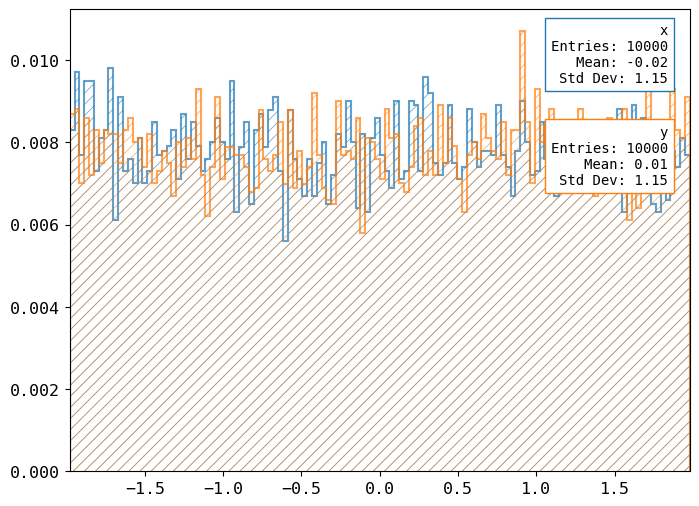

In [20]:
plot_proposal(nfm, n_samples=10000)

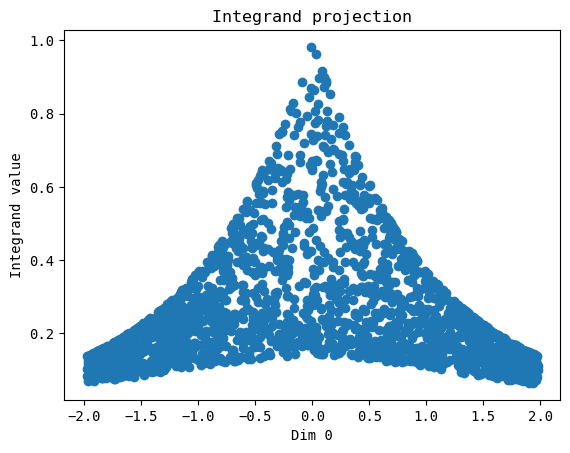

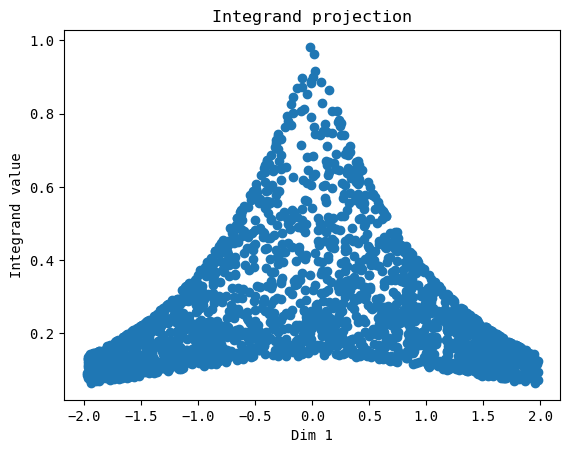

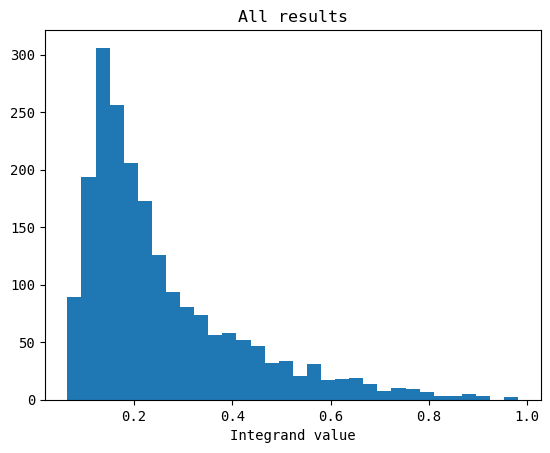

In [17]:
plot_integrand(nfm, func, y_log=False)

In [18]:
get_result(nfm, func, n_samples=4096)

(4.0776872634887695, 0.039701931178569794)

In [96]:
n_samples = 100

samples, logq = nfm.sample(n_samples)
true = torch.abs(func(samples.detach()))
test = logq.exp()
mean = torch.mean(true/test)
var = torch.var(true/test)

print(mean, torch.sqrt(var/(n_samples-1.)).item())

tensor(2.2204, grad_fn=<MeanBackward0>) 0.072452612221241


In [93]:
4.01/2.3243

1.7252506130878114

In [86]:
from math import sqrt

In [87]:
sqrt(1.72525)

1.3134877235817624